In [1]:
import multiprocessing as mp
# mp.set_start_method('forkserver')

import networkx as nx

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy as sp

from itertools import product
from scipy.special import comb

import os


from scipy.spatial.distance import cosine
from scipy.stats import norm

import pytensor.tensor as pt

from IPython.display import display

# RANDOM_SEED = 8927
# rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

We need two NxN matrices, one for each network statistic. Each cell in each matrix indicates how the presence of that potential edge would change that statistic, holding the rest of the network constant.

For the edge count, the matrix is just all 1s -- since any new edge, by definition, increases the edge count by 1.

Gender matching is a specific example of attribute matching: we want a matrix $M$ such that $M_{ij} = 1$ if nodes $i$ and $j$ have the same attribute value (e.g. their gender), and otherwise 0.

In [2]:
def edge_delta(am, undirected=True):
    n = am.shape[0]
    dm = np.ones((n, n))
    if undirected:
        dm[np.triu_indices_from(dm)] = 0
    return dm

def triangle_delta(am):
    n = am.shape[0]
    dm = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                row_sum = np.add(dm[i], dm[j])
                dm[i][j] = len(row_sum[row_sum > 1])
    # if not G.is_directed():
    #     dm[np.triu_indices_from(dm)] = 0
    return dm

def star_delta(am, k):
    if k == 1:
        # if k == 1 then this is just density
        dm = np.ones(am.shape)
        print(dm)
    dm = np.zeros(am.shape, dtype=int)
    n = am.shape[0]
    for i, j in product(range(n), range(n)):
        if i != j:
            nin = am[i,:].sum() - am[i,j]
            dm[i,j] = comb(nin, k-1, exact=True)
    print(dm)

def istar_delta(am, k):
    if k == 1:
        # if k == 1 then this is just density
        dm = np.ones(am.shape)
        return dm
    dm = np.zeros(am.shape, dtype=int)
    n = am.shape[0]
    for i, j in product(range(n), range(n)):
        if i != j:
            nin = am[:,j].sum() - am[i,j]
            dm[i,j] = comb(nin, k-1, exact=True)
    return dm

def ostar_delta(am,k):
    if k == 1:
        # if k == 1 then this is just density
        dm = np.ones(am.shape)
        return dm
    dm = np.zeros(am.shape,dtype=int)
    n = am.shape[0]
    for i, j in product(range(n), range(n)):
        if i!=j:
            nin = am[i,:].sum() - am[i,j]
            dm[i,j] = comb(nin, k-1, exact=True)
    return dm

def continuous_distance_delta(am, attrs):
    n = am.shape[0]
    dm = np.zeros(shape=(n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dm[i,j] = cosine(attrs[i], attrs[j])
    # if not G.is_directed():
    #     dm[np.triu_indices_from(dm)] = 0
    return dm

def discrete_distance_delta(am, vecs):
    n = am.shape[0]
    dm = np.zeros(shape=(n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dm[i,j] = cosine(vecs[i], vecs[j])
    dm[dm >= np.median(dm)] = 1
    dm[dm < np.median(dm)] = 0
    # if not G.is_directed():
    #     dm[np.triu_indices_from(dm)] = 0
    return dm


In [12]:
# n = 100

field_name = 'Economics'
file = f'../output/co_occurence_graphs/{field_name}.edgelist'

G = nx.read_weighted_edgelist(file)

am = nx.to_numpy_array(G)

density = edge_delta(am)
triangles = triangle_delta(am)
# istar2 = istar_delta(am, 2)
# istar3 = istar_delta(am, 3)

# distance = discrete_distance_delta(am, np.random.normal(loc=0, scale=1, size=(len(G), 10)))

am[np.triu_indices_from(am)] = 0

with pm.Model() as model:

    # error = pm.HalfNormal('error', sigma=100)
    # intercept = pm.Normal('intercept', mu=0, sigma=100)

    density = pm.ConstantData("density", density)
    # triangles = pm.ConstantData("triangles", triangles)
    # istar2 = pm.ConstantData("istar2", istar2)
    # istar3 = pm.ConstantData("istar3", istar3)
    # distance = pm.ConstantData("distance", distance)

    β_density = pm.Normal('β_density', sigma=1)
    # β_triangles = pm.Normal('β_triangles', sigma=100)
    # β_istar2 = pm.Normal('β_istar2', mu=0, sigma=100)
    # β_istar3 = pm.Normal('β_istar3', mu=0, sigma=100)
    # β_distance = pm.Normal('β_distance', mu=0, sigma=100)

    μ = β_density*density # + β_triangles*triangles + β_istar2*istar2 + β_istar3*istar3 + β_distance*distance 
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    
    y = pm.Bernoulli('y', p=θ, observed=am)

    #samples from posterior distribution 
    trace=pm.sample(
        draws=30000, 
        tune=1000,
        cores=1,
        start={'β_density': 1}
        # step=None, # NUTS, Metropolis
        # progressbar=False,
    )

/var/folders/rz/n4jmlyh1355cy_wkn5gd00x40000gn/T/ipykernel_55486/4216545179.py:42: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace=pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'β_density': array(0.75830651)}

Initial evaluation results:
{'β_density': -1.21, 'y': -inf}

In [18]:
# print(f'\n{field_name}')
summary = az.summary(trace, kind="stats", var_names=['β_density', 'β_triangles', 'β_istar2', 'β_istar3', 'β_distance'])
display(summary)

KeyError: 'var names: "[\'β_istar2\' \'β_istar3\' \'β_distance\'] are not present" in dataset'

In [53]:
n = 500

files = '/Users/vladimirborel/Documents/GitHub/dissertation/corpus/output/graphs/citation/'

traces = {}

for file in os.listdir(files):

    G = nx.read_edgelist(files + file, create_using=nx.DiGraph())

    centrality_map = nx.in_degree_centrality(G)
    sorted_centrality_map = sorted(centrality_map.items(), key=lambda x: x[1], reverse=True)
    most_central_map = dict(sorted_centrality_map[:n])
    most_central_nodes = most_central_map.keys()

    G = G.subgraph(most_central_nodes)

    am = nx.to_numpy_array(G)

    density = edge_delta(am)
    triangles = triangle_delta(am)
    istar2 = istar_delta(am, 2)
    istar3 = istar_delta(am, 3)

    distance = discrete_distance_delta(am, np.random.normal(loc=0, scale=1, size=(len(G), 10)))

    am
    # am[np.triu_indices_from(am)] = 0

    with pm.Model() as model:

        density = pm.ConstantData("density", density)
        triangles = pm.ConstantData("triangles", triangles)
        istar2 = pm.ConstantData("istar2", istar2)
        istar3 = pm.ConstantData("istar3", istar3)
        distance = pm.ConstantData("distance", distance)

        β_density = pm.Normal('β_density', mu=0, sigma=100)
        β_triangles = pm.Normal('β_triangles', mu=0, sigma=100)
        β_istar2 = pm.Normal('β_istar2', mu=0, sigma=100)
        β_istar3 = pm.Normal('β_istar3', mu=0, sigma=100)
        β_distance = pm.Normal('β_distance', mu=0, sigma=100)

        μ = β_density*density + β_triangles*triangles + β_istar2*istar2 + β_istar3*istar3 + β_distance*distance
        θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
        
        y_1 = pm.Bernoulli('y', p=θ, observed=am)

        #samples from posterior distribution 
        trace=pm.sample(
            draws=500, 
            tune=1000,
            cores=1, 
            step=None, # NUTS, Metropolis
            progressbar=False,
        )
    
        trace_name = file.split('.')[0]
        trace.to_netcdf(f'./pymc_model_traces/{trace_name}.netcdf')

    print(trace_name)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [β_density, β_triangles, β_istar2, β_istar3, β_distance]
Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 1450 seconds.


Political Science


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [β_density, β_triangles, β_istar2, β_istar3, β_distance]
Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 1208 seconds.


Ethnic & Cultural Studies


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [β_density, β_triangles, β_istar2, β_istar3, β_distance]
Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 824 seconds.


Geophysics


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [β_density, β_triangles, β_istar2, β_istar3, β_distance]
Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 3390 seconds.


Gender Studies


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [β_density, β_triangles, β_istar2, β_istar3, β_distance]
Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 1637 seconds.


International Business


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [β_density, β_triangles, β_istar2, β_istar3, β_distance]
Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 1183 seconds.


Human Resources & Organizations


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [β_density, β_triangles, β_istar2, β_istar3, β_distance]
Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 1053 seconds.


Language & Linguistics


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [β_density, β_triangles, β_istar2, β_istar3, β_distance]
Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 1222 seconds.


PermissionError: [Errno 13] Permission denied: b'/Users/vladimirborel/Documents/GitHub/dissertation/corpus/GraphModels/pymc_model_traces/Neurology.netcdf'

In [54]:
files = f'./pymc_model_traces/'

traces = {}
for file in os.listdir(files):
    trace = az.from_netcdf(os.path.join(files, file))
    field_name = file.split('.')[0]
    traces[field_name] = trace


In [55]:
field = 'Geometry'
trace = traces[field]

In [56]:
print(f'\n{field}')
summary = az.summary(trace, kind="stats", var_names=['β_density', 'β_triangles', 'β_istar2', 'β_istar3', 'β_distance'])
display(summary)


Geometry


,mean,sd,hdi_3%,hdi_97%
β_density,-4.240,0.050,-4.333,-4.149
β_triangles,-0.424,97.427,-186.361,184.063
β_istar2,-2.990,0.034,-3.053,-2.925
β_istar3,0.303,0.004,0.296,0.310
β_distance,-4.883,0.077,-5.032,-4.746



Geometry


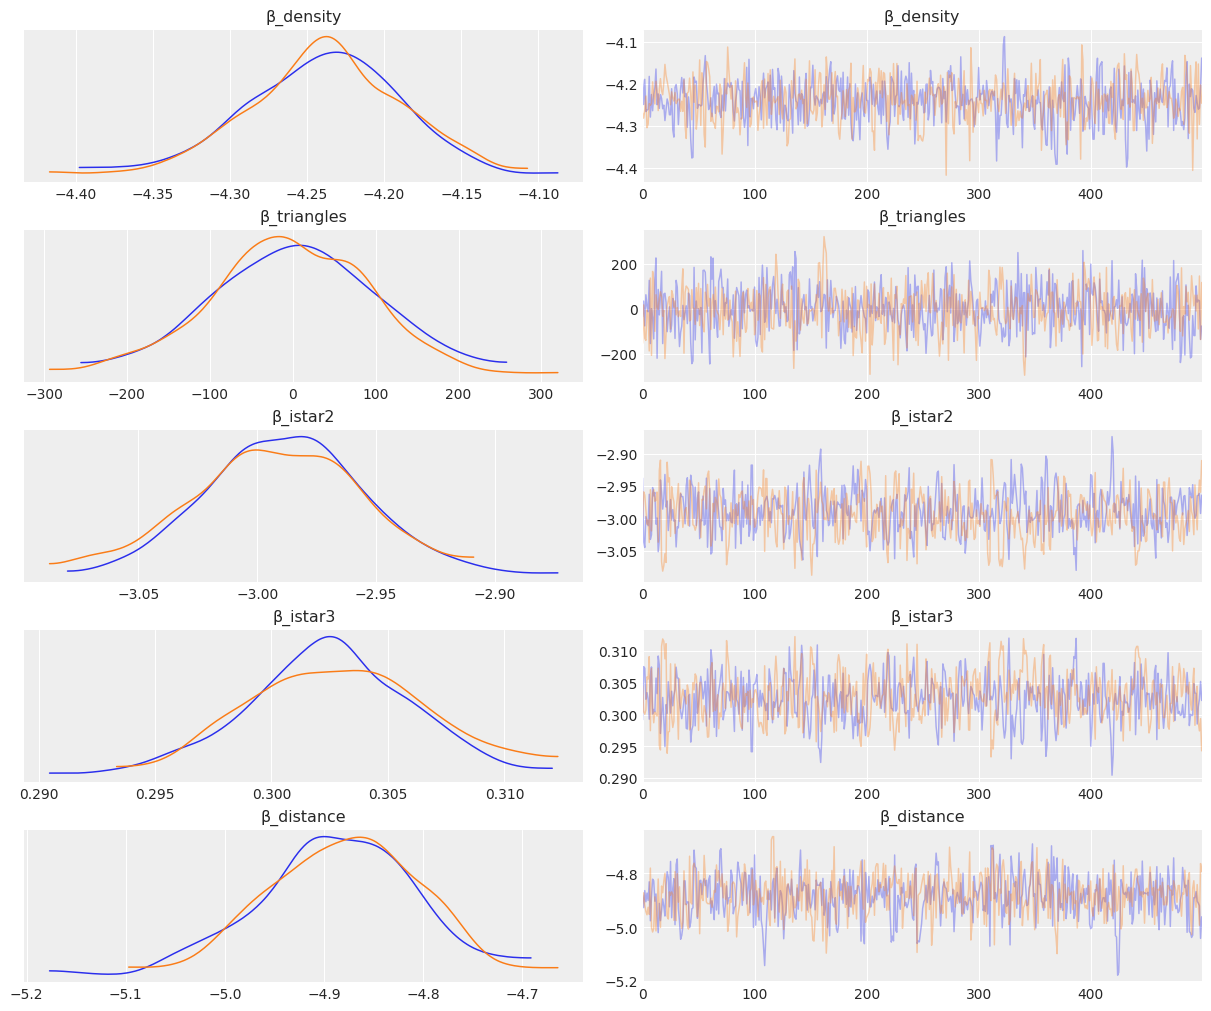

In [57]:
print(f'\n{field}')
az.plot_trace(trace, var_names=['β_density', 'β_triangles', 'β_istar2', 'β_istar3', 'β_distance'], compact=False);
plt.show()

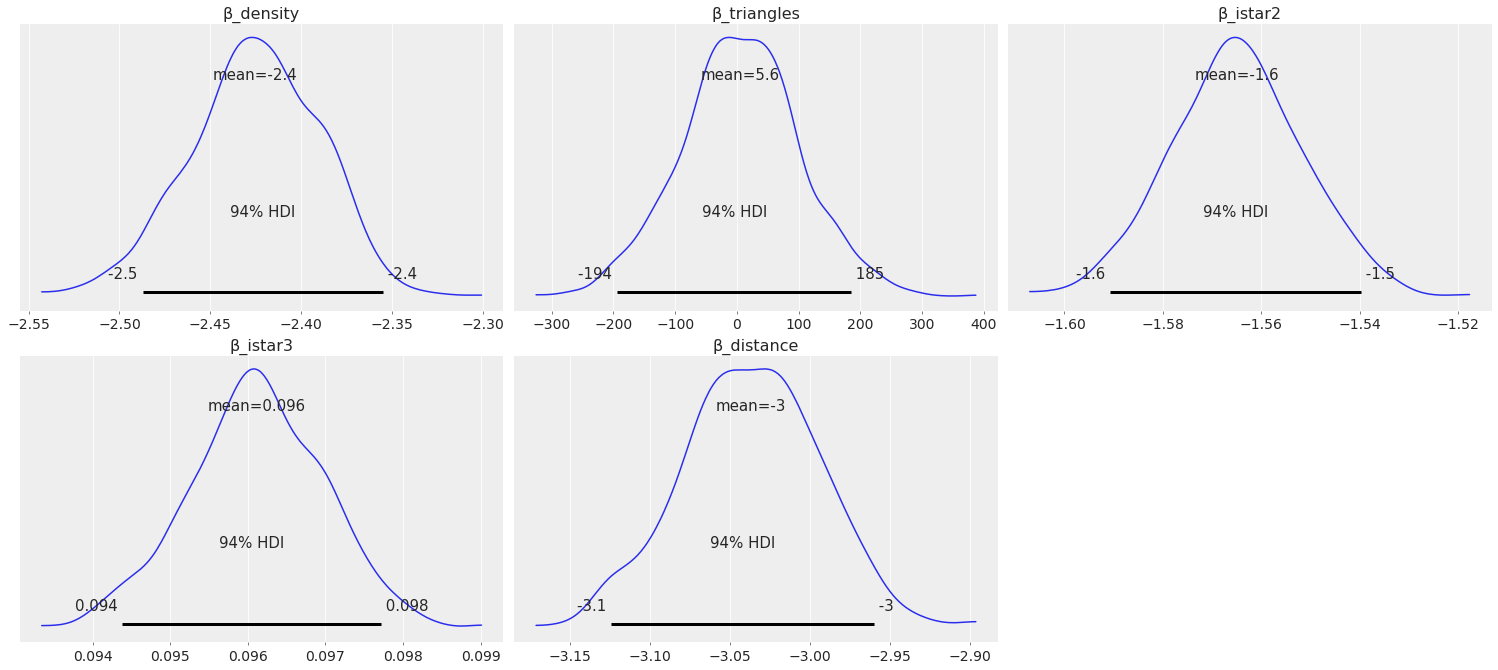

In [12]:
print(field)
az.plot_posterior(trace, var_names=['β_density', 'β_triangles', 'β_istar2', 'β_istar3', 'β_distance'])
plt.show()

In [59]:
for field, trace in traces.items():

    print(f'\n{field}')

    for beta, samples in trace.posterior.data_vars.items():

        if beta == 'θ':
            continue
        
        sample = samples.to_numpy()

        mean = np.mean(sample).round(3)
        stderr = np.std(sample).round(3)
        z_value = (mean / stderr).round(3)
        p_value = (norm.sf(x=abs(z_value)) * 2).round(3)

        match p_value:
            case _ if p_value <= 0.001:
                stars = '***'
            case _ if p_value <= 0.01:
                stars =  '**'
            case _ if p_value <= 0.05:
                stars =  '*'  
            case _ if p_value <= 0.1:
                stars =  '.'  
            case _:
                stars = ' ' 

        print(f'''{beta} {mean} ({stderr}) {z_value} {min(p_value, 1)} {stars}''')


Geometry
β_density -4.24 (0.05) -84.8 0.0 ***
β_triangles -0.424 (97.378) -0.004 0.997  
β_istar2 -2.99 (0.034) -87.941 0.0 ***
β_istar3 0.303 (0.004) 75.75 0.0 ***
β_distance -4.883 (0.077) -63.416 0.0 ***

Political Science
β_density -2.678 (0.031) -86.387 0.0 ***
β_triangles 4.696 (102.76) 0.046 0.963  
β_istar2 -0.887 (0.007) -126.714 0.0 ***
β_istar3 0.043 (0.0) inf 0.0 ***
β_distance -2.781 (0.034) -81.794 0.0 ***

Human Resources & Organizations
β_density -2.812 (0.034) -82.706 0.0 ***
β_triangles -1.014 (100.81) -0.01 0.992  
β_istar2 -0.937 (0.007) -133.857 0.0 ***
β_istar3 0.044 (0.0) inf 0.0 ***
β_distance -2.724 (0.032) -85.125 0.0 ***

Material Engineering
β_density -3.187 (0.039) -81.718 0.0 ***
β_triangles -1.904 (98.62) -0.019 0.985  
β_istar2 -1.535 (0.014) -109.643 0.0 ***
β_istar3 0.112 (0.001) 112.0 0.0 ***
β_distance -3.754 (0.052) -72.192 0.0 ***

Probability & Statistics
β_density -2.933 (0.036) -81.472 0.0 ***
β_triangles -3.011 (99.557) -0.03 0.976  
β_istar2 

/var/folders/rz/n4jmlyh1355cy_wkn5gd00x40000gn/T/ipykernel_46637/3135205247.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  z_value = (mean / stderr).round(3)


In [34]:
# Goodness of fit
# The observed data looks like draws from the posterior distribution

with model:
    ppc = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [y]


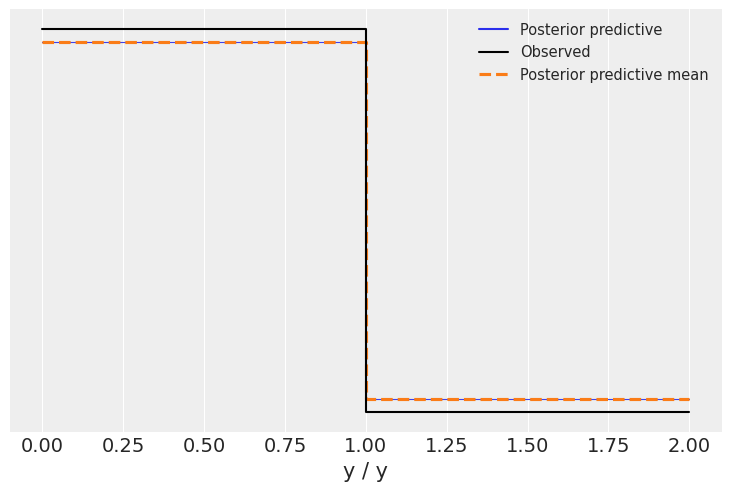

In [35]:
az.plot_ppc(trace, kind='kde', num_pp_samples=10)
plt.show()

In [36]:
az.plot_ppc(trace, kind='cumulative', num_pp_samples=10)
plt.show()

KeyboardInterrupt: 

In [64]:
pm.logp(β_density, 0.1)

Check{sigma > 0}.0

In [65]:
pm.draw(β_density, 10)

array([  88.98073425,  -49.27158685,  121.04007877, -111.25489437,
       -183.25189657,  -92.36878026,   34.83873557, -104.3395341 ,
       -148.17076396,  -94.51463945])